In [ ]:
# https://www.kaggle.com/moseswmwong/electra-tweets-classifier 참조

In [ ]:
pip install torch_optimizer

     |████████████████████████████████| 72 kB 1.2 MB/s 


In [ ]:
pip install pytorch-lightning

     |████████████████████████████████| 913 kB 8.4 MB/s 
     |████████████████████████████████| 636 kB 59.3 MB/s 
     |████████████████████████████████| 829 kB 64.4 MB/s 
     |████████████████████████████████| 10.6 MB 60.4 MB/s 
     |████████████████████████████████| 118 kB 74.1 MB/s 
     |████████████████████████████████| 234 kB 71.8 MB/s 
     |████████████████████████████████| 1.3 MB 34.6 MB/s 
     |████████████████████████████████| 294 kB 69.6 MB/s 
     |████████████████████████████████| 142 kB 76.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=3b1f1f05d5e1b381bdeec31778ee0a5b168bab433995ea61c5491f0c014604d4
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstal

## **Mecab 설치**

In [ ]:
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
# !sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 448 kB 51.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Reading package lists... Done
Building dependency

## **Transformers 설치**

In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 8.4 MB/s 
     |████████████████████████████████| 3.3 MB 52.7 MB/s 
     |████████████████████████████████| 895 kB 68.8 MB/s 


In [ ]:
pip install pytorchtools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab
mecab = Mecab()

import torch
import torch_optimizer as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# 그래프를 출력창에서 바로 볼 수 있게함
%matplotlib inline 


In [ ]:
my_learning_rate = 3E-6 # default is 5E-5
my_adam_epsilon = 1E-8 # default is 1E-8
my_number_of_epochs = 7
my_warmup = 3
my_mini_batch_size = 128

In [ ]:
"""
GPU를 사용 가능한지 여부를 True, False로 나타냄
torch.cuda.is_available()
 
GPU 이름
torch.cuda.get_device_name(0)
"""
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0)) # GPU device 이름 출력
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

I will use the GPU: Tesla T4


In [ ]:
#################
STOPWORDSPATH ="/content/drive/MyDrive/Colab Notebooks/stopwords.txt"
#################
## Import DATA, submission file
train = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/train_data.csv", error_bad_lines=False  )
test = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/test_data.csv",error_bad_lines=False)
submission = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/sample_submission.csv",error_bad_lines=False)
topic_dict = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/topic_dict.csv",error_bad_lines=False)

In [ ]:
okt = Okt()

# morpheme analysis
def morp_analy(basic_preprocessed_corpus):
    cleaned_ = []
    tag_list = ['Suffix','Josa','Determiner','Modifier']
    for i in basic_preprocessed_corpus:
        i=okt.pos(i,stem=True,norm=True)
        tmp = []
        for (word, pos) in i:
            if (pos not in tag_list) and (len(word) != 1):
                tmp.append(word)
        cleaned_.append(" ".join(tmp))
    return cleaned_

In [ ]:

## preprocessing
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

cleaned_train_corpus = []
cleaned_test_corpus = []

for sent in train['title']:
    cleaned_train_corpus.append(clean_punc(sent, punct, punct_mapping))
    
for sent in test['title']:
    cleaned_test_corpus.append(clean_punc(sent, punct, punct_mapping))


def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        texts[i] = texts[i].replace("外人","외국인")
        texts[i] = texts[i].replace("日","일본")
        texts[i] = texts[i].replace("美","미국")
        texts[i] = texts[i].replace("北","북한")
        texts[i] = texts[i].replace("英","영국")
        texts[i] = texts[i].replace("中","중국")
        texts[i] = texts[i].replace("與","여당")
        texts[i] = texts[i].replace("靑","청와대")
        texts[i] = texts[i].replace("野","야당")
        texts[i] = texts[i].replace("伊","이탈리아")
        texts[i] = texts[i].replace("韓","한국")
        texts[i] = texts[i].replace("南","한국")
        texts[i] = texts[i].replace("獨","독일")
        texts[i] = texts[i].replace("佛","프랑스")
        texts[i] = texts[i].replace("檢","검찰")
        texts[i] = texts[i].replace("銀","은행")
        texts[i] = texts[i].replace("亞","아시아")
        texts[i] = texts[i].replace("人","사람")
        texts[i] = texts[i].replace("孫","손혜원")
        texts[i] = texts[i].replace("企","기업")
        texts[i] = texts[i].replace("前","이전")
        texts[i] = texts[i].replace("反","반대")
        texts[i] = texts[i].replace("安","안철수")
        texts[i] = texts[i].replace("展","전시회")
        texts[i] = texts[i].replace("故","사망")
        texts[i] = texts[i].replace("文","문재인")
        texts[i] = texts[i].replace("新","새로운")
        texts[i] = texts[i].replace("曺","조국")
        texts[i] = texts[i].replace("朴","박정치인")
        texts[i] = texts[i].replace("株","주식")
        texts[i] = texts[i].replace("男","남자")
        texts[i] = texts[i].replace("硏","연구")
        texts[i] = texts[i].replace("車","자동차")
        texts[i] = texts[i].replace("軍","군대")
        texts[i] = texts[i].replace("重","중공업")
        texts[i] = texts[i].replace("R&D","연구개발")
        texts[i] = texts[i].replace("문정부","문재인정부")
        


        
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(review))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        review = re.sub("[一-龥]",'', review)
        corpus.append(review)
    return corpus

basic_preprocessed_train_corpus = clean_text(cleaned_train_corpus)
basic_preprocessed_test_corpus = clean_text(cleaned_test_corpus)


stopwords = []
with open(STOPWORDSPATH) as f:
    for line in f:
        stopwords.append(line.strip())

removed_stopword_train_corpus = []
removed_stopword_test_corpus = []

for tagged in basic_preprocessed_train_corpus:
    tagged=mecab.pos(tagged)
    
    temp = []
    for tag in tagged:
        #일반명사, 고유명사, 동사, 형용사, 긍정지정사, 부정 지정사, 관형사, 일반부사, 체언접두사, 외국어, 한자
        if tag[0] in stopwords or tag[1] not in ["NNG", "NNP", "VV", "VA", "VCP", "VCN", "MM", "MAG", "XPN", "SL", "SH"]:
            continue
        temp.append(tag[0])

    removed_stopword_train_corpus.append(' '.join(temp))
    
for tagged in basic_preprocessed_test_corpus:
    tagged=mecab.pos(tagged)
    
    temp = []
    for tag in tagged:
        if tag[0] in stopwords or tag[1] not in ["NNG", "NNP", "VV", "VA", "VCP", "VCN", "MM", "MAG", "XPN", "SL", "SH"]:
            continue
        temp.append(tag[0])

    removed_stopword_test_corpus.append(' '.join(temp))


"""   
###############최종 전처리###################
"""
train_text = removed_stopword_train_corpus
test_text = removed_stopword_test_corpus
train_label = np.asarray(train.topic_idx)

In [ ]:
train['clear_title'] = train_text
test['clear_title'] = test_text

# train data와 label 데이터 설정
texts = train['clear_title']
labels = train['topic_idx']

#take a look at the first 50 training examples
for n in range(50):
    print(texts[n], "(LABEL:", labels[n], ")")


인천 핀란드 항공기 결항 휴가철 여행객 분통 (LABEL: 4 )
실리콘밸리 넘어서 구글 조원 미국 전역 거점 (LABEL: 4 )
이란 외무 긴장 완화 해결책 미국 경제 전쟁 멈추 (LABEL: 4 )
nyt 클린턴 측근 한국 기업 특수 관계 조명 공과 종합 (LABEL: 4 )
시진핑 트럼프 중미 무역 협상 조속 타결 희망 (LABEL: 4 )
팔레스타인 가 세 소년 이스라엘 총격 사망 (LABEL: 4 )
인도 파키스탄 공습 테러 캠프 폭격 종 합보 (LABEL: 4 )
미국 대선 tv 토론 음담패설 만회 실패 트럼프 사과 대신 빌클린턴 공격 역효과 (LABEL: 4 )
푸틴 한반도 상황 진전 방안 김정은 위원장 논의 (LABEL: 4 )
특검 면죄부 받 트럼프 스캔들 보도 언론 맹공 국민 적 (LABEL: 4 )
일본 오키나와 강제 징용 노동자 추도식 (LABEL: 4 )
이란 최고 지도자 모욕 혐의 미국인 징역 선고 (LABEL: 4 )
카니발 축제 보 브라질 리우 대형 유람선 행렬 (LABEL: 4 )
미국 올랜도 병원 최악 총기 테러 부상자 치료비 안 받 (LABEL: 4 )
일본 대 기업 올해 평균 임금 인상 (LABEL: 4 )
wmo 엘니뇨 여전히 강력 분기 소멸 (LABEL: 4 )
이스라엘 네타냐후 유대교 병역 문제 연정 협상 진통 (LABEL: 4 )
uae 사우디 이 미국 호르무즈 호위 연합 참여 (LABEL: 4 )
사우디 오만 유조선 공격 예멘 반군 연결 이 겨냥 (LABEL: 4 )
개천 용 미국 사업가 모교 장학금 기부 (LABEL: 4 )
eu 브렉 시트 합의 전 일 많 영국 경고 (LABEL: 4 )
스팍스 운용 일본 디플레 도약 준비 (LABEL: 4 )
트럼프 총기 난사 의 공격 총기 규제 초당 협력 촉구 종합 (LABEL: 4 )
nba 카지노 업체 스폰서 계약 미국 프로 스포츠 사상 처음 (LABEL: 4 )
오바마 대통령 퇴임 후 워싱턴 dc 사무실 개소 예정 (LABEL: 4 )
미국 전문가 트럼프 정부 북한 정상

In [ ]:
"""
Electra is selected here, its pretraining method is more advanced than BERT's MLM. 
AdamW is Adam with weight decay correction.
"""
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator") 
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator",num_labels=7) #let's try out electra's base discriminator


# tensor를 만든후 GPU에 할당하고 싶을 때  

# a = torch.tensor([1., 2.], device=cuda)
 
# b = torch.tensor([1., 2.]).cuda()

# b2 = torch.tensor([1., 2.]).to(device=cuda)


# 아니면 Model을 선언후 모든 parameter를 
# model.cuda()를 통해 GPU에 로딩할 수 있음


model.cuda()

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

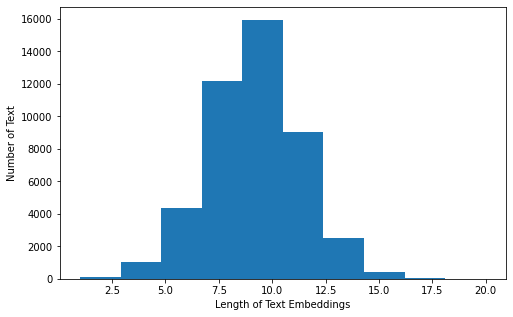

In [ ]:
import matplotlib.pyplot as plt
def plot_sentence_text_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len);
    ax.set_xlabel("Length of Text Embeddings");
    ax.set_ylabel("Number of Text");
    return
plot_sentence_text_length(texts, tokenizer)

In [ ]:
indices=tokenizer.batch_encode_plus(texts,
                                    max_length=32,
                                    add_special_tokens=True, 
                                    return_attention_mask=True,
                                    pad_to_max_length=True,
                                    truncation=True)

# bert와 달리(bert는 3개) input data가 2개임

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

"""
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]
"""
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
type(validation_inputs)

list

In [ ]:

# 만들어진 모든 data를 torch.tensor을 통해 tensor로 변환
# torch.long 은  np.int64 와 같음

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels.tolist(), dtype=torch.long) # list 변환 해줘야함
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:

# pytorch는  torch.utils.data.Dataset으로 Custom Dataset을 만들고, 
# torch.utils.data.DataLoader로 데이터를 불러옴 

batch_size = my_mini_batch_size

"""Create the DataLoader for our training set."""
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#### DataLoader ###
# DataLoader를 통해 반복분을 돌리면  (batch_size, *(data.shape))의 형태의 Tensor로 데이터가 반환
# sampler : index를 컨트롤하는 방법, 즉 데이터의 index를 원하는 방식대로 조정
# sampler option 

# SequentialSampler : 항상 같은 순서
# RandomSampler : 랜덤, replacemetn 여부 선택 가능, 개수 선택 가능

# SubsetRandomSampler : 랜덤 리스트, 위와 두 조건 불가능
# WeigthRandomSampler : 가중치에 따른 확률
# BatchSampler : batch단위로 sampling 가능
# DistributedSampler : 분산처리 (torch.nn.parallel.DistributedDataParallel과 함께 사용)


""" Create the DataLoader for our validation set."""
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data) 
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = my_learning_rate, #args.learning_rate
                  eps = my_adam_epsilon  #args.adam_epsilon

                )
# optimizer = optim.RAdam(
#     model.parameters(),
#     lr= 3e-6,
#     betas=(0.9, 0.999),
#     eps=1e-8,
#     weight_decay=0,
# )

"""
my_learning_rate = 3E-6 # default is 5E-5
my_adam_epsilon = 1E-8 # default is 1E-6
my_number_of_epochs = 7
my_warmup = 3
my_mini_batch_size = 128

"""


# epoch 수 설정
epochs = my_number_of_epochs

# Total number of training steps is number of batches * number of epochs.
# batchs * epoch 수 만큼의 훈련을 함
total_steps = len(train_dataloader) * epochs

""" warmup
내가 정한 learning rate가 0.01이라고 한다면 처음 10 step 동안은 
0.001, 0.002, 0.003 ~ 0.01까지 선형적으로 조금씩만 증가하는 learning rate을 사용

이러한 방식은 warmup step을 따로 정해줘야 함
"""

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = my_warmup, 
                                            num_training_steps = total_steps)

In [ ]:

#about evalution mert - here we use accuracy, which is good enough because the data is
#is binary classified and distribution is pretty even between positive and negative
#however better evaluation should be use later F1 or AUC ROC because emergency are
#events rare tweets

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### **Early Stopping**

## **Training**

In [ ]:
import random

# Base on GLUE from huggingface, this is classification problem best suit our problem, here, look at the
# example Python code from hungingface gtihub, here is the here training loop

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128



# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors: [0]: input ids ,[1]: attention masks,[2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients.
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Evaluate the model on this training batch.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0. to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)       
     # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
   

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")




======== Epoch 1 / 7 ========
Training...
  Batch    50  of    286.    Elapsed: 0:00:31.
  Batch   100  of    286.    Elapsed: 0:01:03.
  Batch   150  of    286.    Elapsed: 0:01:37.
  Batch   200  of    286.    Elapsed: 0:02:13.
  Batch   250  of    286.    Elapsed: 0:02:48.

  Average training loss: 1.80
  Training epoch took: 0:03:13

======== Epoch 2 / 7 ========
Training...
  Batch    50  of    286.    Elapsed: 0:00:35.
  Batch   100  of    286.    Elapsed: 0:01:11.
  Batch   150  of    286.    Elapsed: 0:01:46.
  Batch   200  of    286.    Elapsed: 0:02:21.
  Batch   250  of    286.    Elapsed: 0:02:56.

  Average training loss: 1.29
  Training epoch took: 0:03:21

======== Epoch 3 / 7 ========
Training...
  Batch    50  of    286.    Elapsed: 0:00:35.
  Batch   100  of    286.    Elapsed: 0:01:11.
  Batch   150  of    286.    Elapsed: 0:01:46.
  Batch   200  of    286.    Elapsed: 0:02:21.
  Batch   250  of    286.    Elapsed: 0:02:57.

  Average training loss: 0.95
  Training 

In [ ]:
# Validation
print("")
print("Running Validation...")

t0 = time.time()
model.eval()

preds=[]
true=[]

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))
    


Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:17


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions,flat_true_labels))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1066
           1       0.80      0.82      0.81      1201
           2       0.72      0.78      0.75      1373
           3       0.89      0.86      0.88      1162
           4       0.92      0.90      0.91      1520
           5       0.96      0.95      0.95      1455
           6       0.89      0.89      0.89      1354

    accuracy                           0.86      9131
   macro avg       0.86      0.86      0.86      9131
weighted avg       0.86      0.86      0.86      9131



In [ ]:
text1 = test['clear_title']

indices1=tokenizer.batch_encode_plus(text1,
                                     max_length=32,
                                     add_special_tokens=True, 
                                     return_attention_mask=True,
                                     pad_to_max_length=True,
                                     truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = my_mini_batch_size

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:

  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

    logits1 = outputs1[0]

  # Move logits and labels to CPU
    logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
    predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions_1 = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 9,131 test sentences...


In [ ]:
import torch.nn.functional as F

In [ ]:
z = torch.FloatTensor(flat_predictions_1)

In [ ]:
flat_predictions_1[0]

array([ 1.2122238 ,  0.16308124,  1.2969455 ,  1.0561376 , -1.0353398 ,
       -1.0351627 , -1.4420086 ], dtype=float32)

In [ ]:
z[0]

tensor([ 1.2122,  0.1631,  1.2969,  1.0561, -1.0353, -1.0352, -1.4420])

In [ ]:
probs_1 = F.softmax(z, dim=1)

In [ ]:
probs_1 = (probs_1).tolist()

In [ ]:
probs_1[0]

[0.27965599298477173,
 0.0979461520910263,
 0.3043815493583679,
 0.23924164474010468,
 0.029547426849603653,
 0.02955266647040844,
 0.01967458985745907]

In [ ]:
flat_predictions

array([2, 3, 2, ..., 3, 2, 2])

In [ ]:
flat_predictions_1

[array([ 1.2122238 ,  0.16308124,  1.2969455 ,  1.0561376 , -1.0353398 ,
        -1.0351627 , -1.4420086 ], dtype=float32),
 array([-0.22718133, -0.66198474, -0.08543328,  2.9329722 , -0.10479865,
        -0.20969051, -1.0409878 ], dtype=float32),
 array([ 0.35774395,  0.5241354 ,  2.1526663 , -0.31615674, -0.8939342 ,
        -1.2182225 , -0.7004411 ], dtype=float32),
 array([-0.22023918,  0.03454417,  2.3105989 ,  0.09744108, -0.70889837,
        -1.0747092 , -0.34496936], dtype=float32),
 array([-0.17240204, -0.60301507, -0.02419773,  2.9495018 , -0.17190701,
        -0.29599112, -1.0464834 ], dtype=float32),
 array([ 0.89214975,  0.25516975,  1.8263614 ,  0.47360086, -0.989437  ,
        -1.1430154 , -1.1428205 ], dtype=float32),
 array([-0.46563825, -1.1607256 , -0.8429417 , -0.54051423, -0.3891192 ,
         3.0751061 , -0.98893815], dtype=float32),
 array([-0.23854515, -0.5766373 ,  0.08759883,  2.9036138 , -0.13869306,
        -0.31771958, -1.073539  ], dtype=float32),
 array([

In [ ]:
i, j, k=  [], [], []
m, n, o = [], [], []
l = []
for row in probs_1:
  i.append(row[0])
  j.append(row[1])
  k.append(row[2])
  l.append(row[3])
  m.append(row[4])
  n.append(row[5])
  o.append(row[6])


In [ ]:
submission_1 = submission
submission_1['0'] = i
submission_1['1'] = j
submission_1['2'] = k
submission_1['3'] = l
submission_1['4'] = m
submission_1['5'] = n
submission_1['6'] = o

In [ ]:
submission_1.topic_idx = flat_predictions

In [ ]:
submission_1[:12]

,index,topic_idx,0,1,2,3,4,5,6
0,45654,2,0.279656,0.097946,0.304382,0.239242,0.029547,0.029553,0.019675
1,45655,3,0.034525,0.022351,0.039782,0.813889,0.039019,0.035134,0.015300
2,45656,2,0.104716,0.123673,0.630284,0.053375,0.029951,0.021656,0.036345
3,45657,2,0.055097,0.071085,0.692239,0.075700,0.033799,0.023444,0.048636
4,45658,3,0.035970,0.023385,0.041716,0.816144,0.035988,0.031788,0.015008
5,45659,2,0.194334,0.102781,0.494620,0.127872,0.029606,0.025391,0.025396
6,45660,5,0.025460,0.012705,0.017458,0.023623,0.027485,0.878182,0.015087
7,45661,3,0.034825,0.024834,0.048254,0.806323,0.038481,0.032174,0.015110
8,45662,4,0.015911,0.011734,0.022308,0.024277,0.852624,0.026682,0.046463
9,45663,4,0.020561,0.044691,0.040892,0.027186,0.748610,0.022746,0.095313


In [ ]:
# pred = np.argmax(predictions, axis = 1)
submission.topic_idx = flat_predictions
submission.sample(3)

#submission.to_csv(path, index = False)

,index,topic_idx
4043,49697,6
3573,49227,6
4505,50159,3


In [ ]:
submission

,index,topic_idx
0,45654,0
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,3
9129,54783,2


In [ ]:
submission_1.to_csv('/content/koelectra_baseline_1.csv',index = False)
# submission.to_csv('bert_baseline_1.csv',index = True)

In [ ]:
submission.to_csv('/content/koelectra_baseline_1.csv',index = False)
# submission.to_csv('bert_baseline_1.csv',index = True)

In [ ]:
!pip install /content/dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl


In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'/content/koelectra_baseline_1.csv', # 파일경로
'591e4cc451e158618dd98e6bb04ea7364cc18bb044c8877f1ff07542e24cd634',  # 개인토큰
'235747', # 대회 id
'Healthy Guys',  # 팀이름
'koelectra_AdamW') # 노트

{'isSubmitted': True, 'detail': 'Success'}
